<a href="https://colab.research.google.com/github/omanofx/portfolio/blob/main/data_wrangling/excel_cleaning_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Omar Fernández

# The Project

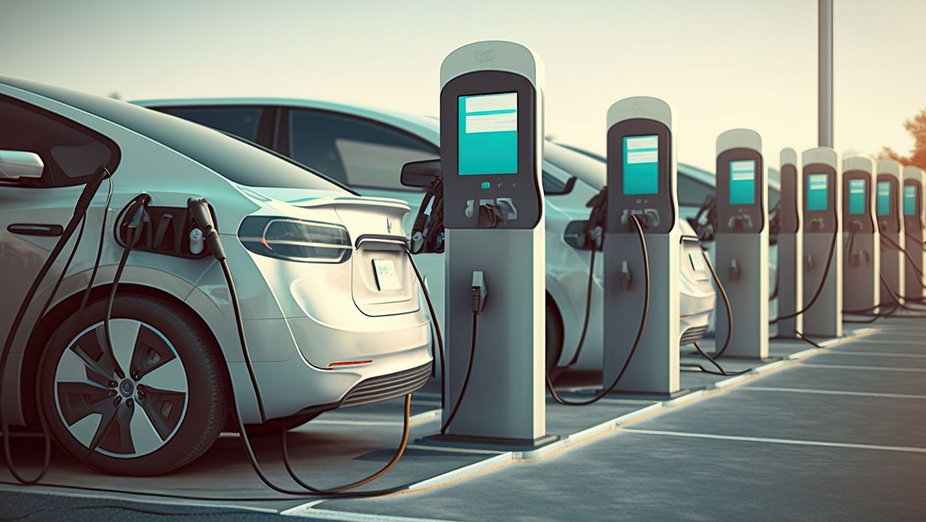

# Table of Contents

1. Executive Summary
1. Introduction
  1. Objective of the project
  1. Stakeholders
  1. Project Scope
  1. Assumptions and limitations
  1. Solution
1. Analytical context
  1. The Dataset
  1. Data set structure
  1. Libraries used
  1. Setting
  1. Functions
1. Data acquisition
  1. Github
1. Data wrangling
  1. Main data set
  1. Target variable
  1. Feature Reduction
  1. Duplicate values
  1. NaN values
  1. Wrong values
  1. Data type transformation
  1. Save file
1. Final project results
1. References
1. Change log

# Executive Summary

# Introduction

## Objective of the project

The objective of this project is to obtain a normalized data set, which can be used in future data analysis and machine learning projects.

## Stakeholders

Any person or entity who wants to use the result of the project to carry out their own analysis and machine learning projects.

## Project Scope

## Assumptions and limitations

The information contained in the spreadsheet shows the historical count of alternative fuel service stations by State annually from December 2007 until the last update in December 2023. The structure of the file tabs as described in 'The dataset' section.

## Solution

# Analytical context

## The dataset (update 2024)

The data is presented in an Excel tab, where each one represents the information collected for a specific calendar year. The tabs have a file design from 2007 to 2013, and another onwards, incorporating a greater level of detail in some alternative fuels. They all have the total count of fuel types in the 'Total' row at the bottom of each tab and the 'Total' per column.

Note that changes in total counts represent both stations that opened and those that went out of service. For example, if the number of stations increased from 200 to 210 in one year, it could have been that 15 stations opened and 5 stations went out of service.

Please note the following regarding electric vehicle (EV) charging station data counts:

Starting in 2011, electric vehicle charging was counted by point of sale and not by geographic location.

As of 2014, historical EV charging data includes both the number of EV charging station locations and the number of outlets at each location.

As of 2014, EV charging data is provided by charger level.

In turn, also since 2014, propane station data is broken down by primary or secondary designations.

* More data sets: https://afdc.energy.gov/data_download

* Historical data set (since 2007): https://afdc.energy.gov/stations/states?count=total&include_temporarily_unavailable=false&date=

* Using API to get the data: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/

## Data set structure

Data set structure

**Years 2007 - 2013:**
- **State**: Name of State of United States of America.
- **Biodiesel**: only includes stations offering biodiesel blends of 20% (B20) and above for a certain period of time during the year. The available blends at each station location are displayed when the station location is selected.
- **CNG**: Compressed natural gas stations that sell renewable natural gas (RNG)
- **E85**: includes stations offering high-level ethanol-gasoline blends (E85). Users may limit their search to E85 stations offering mid-level blends, such as E30.
- **Electric**: Total number of electric vehicle charging stations.
- **LNG**: liquified natural gas stations that sell renewable natural gas (RNG).
- **Hydrogen**: Fuel cell electric vehicle drivers have access to hydrogen stations in certain areas of the country. Because this technology is in the early commercialization stages, the status of hydrogen fueling stations may change more frequently than other fuel types.
- **Propane**: Propane (Liquefied Petroleum Gas, LPG) Stations
- **Total**: Totals are the number of station locations for all fuel types combined.

**Since 2014, it adds these columns:**

- **Electric outlets**: EV charging outlets.
- **Electric Level 1**: total Level 1 charging ports.
- **Electric Level 2**: total Level 2 charging ports.
- **Electric DC Fast**: total DC Fast charging ports.

- **Hydrogen retail**: Retail hydrogen stations accept payment at the point of sale.
- **Hydrogen non-retail**: Non-retail hydrogen stations are only available to a certain subset of customers (e.g., require an access card, PIN, or training).

- **Hydrogen total**: total hydrogen stations

- **Propane primary**: Primary propane stations offer vehicle-specific fueling capabilities.
- **Propane secondary**: Secondary propane stations have fuel available for use in vehicles but limited vehicle fueling services.
- **Propane total**: total propane stations
- **Renewable Diesel**: only includes stations offering renewable diesel blends of 20% (R20) and above for a certain period of time during the year.

**Notes**:
Individual stations count multiple times if the station offers more than one fuel type.
For electric, the total includes charging ports rather than station locations.
For hydrogen, the total includes all (retail and non-retail) stations.
For propane, the total includes all (primary and secondary) stations.


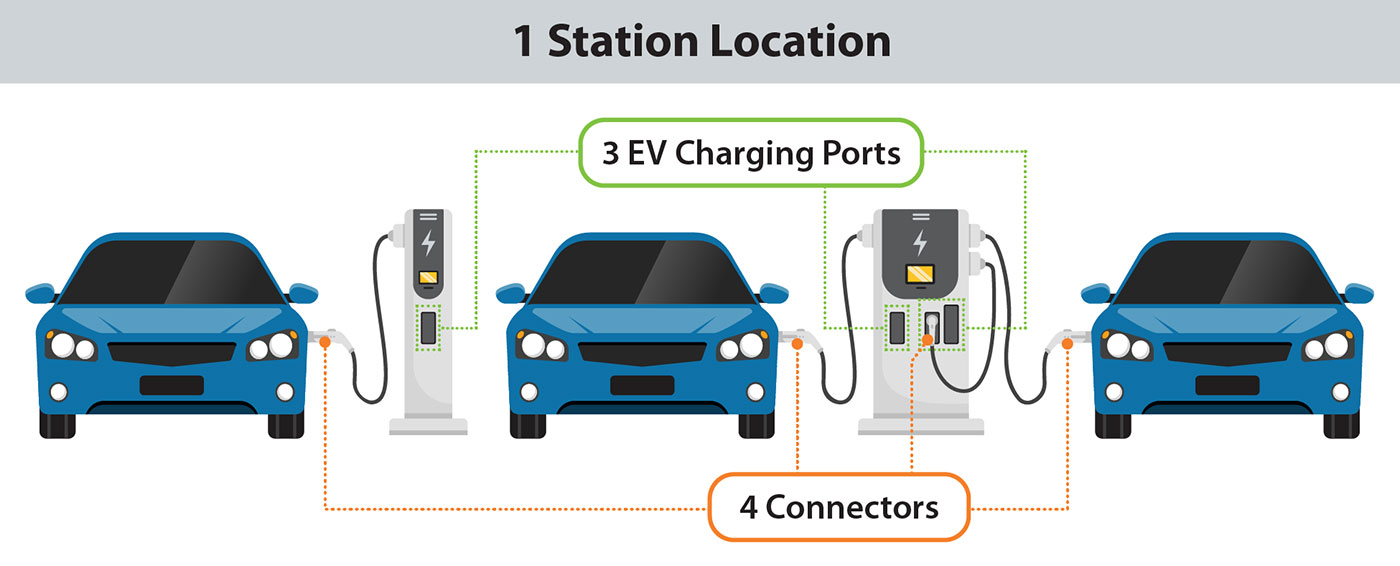

## Libraries used

In [ ]:
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Other
import datetime
from datetime import datetime, timedelta

# Set the local time zone
import pytz

# Additional settings
%matplotlib inline

# Import warnings module
import warnings
warnings.filterwarnings('ignore')

# File import
import requests
from openpyxl import load_workbook
from io import BytesIO

## Setting

In [ ]:
# Set the local time zone
time_zone = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

# Record separator
my_separator = "|"

## Functions

In [ ]:
def split_column_and_concat(df: pd.DataFrame, column_name: str, separator='|', new_column_names=None, ):
    """
    Split a column of a DataFrame into new columns using a separator
     and concatenate these new columns to the original DataFrame.

     Parameters:
     df (pandas.DataFrame): Original DataFrame.
     column_name (str): Name of the column to be split.
     separator (str): Separator used to divide the column values.
     new_column_names (list): Optional list of names for the new columns resulting from the split.
                              If not provided, names will be automatically generated.

     Returns:
     pandas.DataFrame: DataFrame with the new columns resulting from the division concatenated to the original.
    """
    if df[column_name].dtype == 'float64':
      print(f"There are no pipies characters in the analyzed column.", column_name)
      return

    # Split column values into new columns
    new_columns = df[column_name].str.split(separator, expand=True)

    # Generate column names if not provided
    if new_column_names is None:
        new_column_names = [f"{column_name}_{i+1}" for i in range(new_columns.shape[1])]

    # Assign names to new columns
    new_columns.columns = new_column_names

    # Concatenate the new columns to the original DataFrame
    df = pd.concat([df, new_columns], axis=1)

    return df

In [ ]:
def procesar_hoja(df_temp: pd.DataFrame):
  try:
      #Delete 'Total' and subsequent row
      indice_maximo = len(df_temp) -1 # Starts at 0
      ix_columna_total = df_temp[df_temp['State'] == 'Total'].index[0]

      if indice_maximo == ix_columna_total:
        df_temp.drop(index = ix_columna_total, inplace=True)

      else:
        # There are records after 'Total'
        df_temp.drop(index=[ix_columna_total,
                            ix_columna_total +1], inplace=True)

      # deletes records when 'State' and 'Total' columns are NaN
      df_temp = df_temp.dropna(subset=['State','Electric', 'Total'],how='all')

      # Delete records with all NaN columns
      df_temp = df_temp.dropna(how='all')

      # Add a new 'Year' column with the sheet name
      df_temp['Year'] = int(hoja)

      # Replaces characters
      df_temp = df_temp.replace('/', '|', regex=True)
      df_temp = df_temp.replace(',', '', regex=True)

      return df_temp

  except Exception as e:
        # In case of error, print the error and return None
        print("Error processing the excel sheet:", str(e))
        return None

In [ ]:
def fecha_hora_local(local_timezone: pytz.timezone = pytz.timezone('America/Argentina/Buenos_Aires')):
    '''
    This function displays the local date and time each time it is invoked.
     :param local_timezone: The desired local time zone (default 'America/Argentina/Buenos_Aires').
     :return: The local date and time in the specified format.
    '''
    try:
        # Gets the current local time in UTC
        utc_now = datetime.utcnow()

        # Convert current time to local time
        local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(local_timezone)

        # Output format for local date and time
        formato_fecha_hora = "%Y-%m-%d %H:%M:%S"

        # Returns the formatted local date and time
        return local_time.strftime(formato_fecha_hora)

    except Exception as e:
        # In case of error, print the error and return None
        print("Error getting local date and time:", str(e))
        return None

In [ ]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    Physically stores the data obtained in a CSV file.
     :param filename: The base name of the CSV file.
     :param df: The DataFrame that you want to save in the CSV file.
     '''
    try:
        # Gets the current date and time to add to the file name
        fecha_y_hora_actual = fecha_hora_local(time_zone)

        # Specifies the path and name of the CSV file
        ruta_archivo_csv = f"{nombre_archivo}_{fecha_y_hora_actual}.csv"

        # Save the DataFrame to a CSV file without including the index
        df.to_csv(ruta_archivo_csv, index = False)

        # Prints the save date and time and file path
        print("Date and Time:", fecha_y_hora_actual)
        print(f"Data has been saved in CSV file: {ruta_archivo_csv}")

    except Exception as error:
        #Handles any errors that may occur during the save process
        print(f"An error occurred while saving data to CSV file: {error}")

In [ ]:
def tiene_espacios_en_blanco(columna: str) -> bool:
    '''
    Verifica si una columna contiene espacios en blanco.
    :param columna: La columna a ser verificada (str).
    :return: True si la columna contiene al menos un espacio en blanco, False de lo contrario.
    '''
    try:
        # Utiliza una expresión generadora y la función any para verificar si
        # alguno de los caracteres es un espacio en blanco
        return any(caracter.isspace() for caracter in columna)

    except Exception as e:
        # En caso de error, imprime el error y retorna False
        print("Error al verificar espacios en blanco en la columna:", str(e))
        return False

In [ ]:
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del DataFrame. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    #### Version 2.0
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()
    es_categorica = [True if tipo == 'object' else False for tipo in tipo_dato]
    total_ceros_por_columna = [(columna, (df1[columna] == 0).sum()) for columna in df1.columns]

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No Nulos': valores_no_nulos_por_columna,
        'Total Nulos': total_nulos,
        '% Nulos': round(porcentaje_perdidos, 2),
        'Borrar?': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Total Ceros': [total for columna, total in total_ceros_por_columna],
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: green' if x == 'object' else '',
                  subset=['Tipo de dato'])
        .applymap(lambda x: 'background-color: red' if x > porcentaje_tolerancia else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['% Nulos'] > porcentaje_tolerancia].index, '% Nulos'])
        .background_gradient(cmap='Reds', subset=['% Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['Columna con Espacios']].index, 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )

    return estilo_resultado

# Data acquisition

## Github

Read the historical excel file.

In [ ]:
# URL del archivo .xlsx en GitHub
url = 'https://github.com/omanofx/portfolio/raw/main/data_wrangling/historical-station-counts.xlsx'

try:
    # Create an empty DataFrame
    df_hojas = pd.DataFrame()

    # Specify the path of your Excel file
    archivo_excel = url

    # Read the Excel file
    excel_file = pd.ExcelFile(archivo_excel)

    # Gets the names of the sheets in the Excel file
    hojas = excel_file.sheet_names

    # Delete the first sheet
    hojas.remove("About the Data")

    print(f"Keep only the number sheets.\n", hojas)
    print("\n", fecha_hora_local())

except Exception as e:
    print("An error occurred while loading the excel file:", e)

Keep only the number sheets.
 ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007']

 2024-04-25 10:03:05


# Data wrangling

## Process the historical excel file

In [ ]:
# List to store the processed DFs
list_of_df = []

try:
    print(" --- Loop Start --- \n")
    for hoja in hojas:
        year_sheet = int(hoja)

        print("Processing the sheet: " + hoja, " - News found")
        print(50 * "-")

        # Read data from Excel file and store it in a new DataFrame
        df_hojas = pd.read_excel(archivo_excel, sheet_name= hoja,
                                 header= 0,
                                 comment= '(', skiprows = 3)

        # Assign the correct names to the DF columns
        if year_sheet in range(2007, 2014):
            df_hojas.columns = ['State', 'Biodiesel', 'CNG', 'E85', 'Electric',
                                'Hydrogen', 'LNG', 'Propane', 'Total']

            # Add a new column 'Renewable Diesel'
            df_hojas.insert(8, 'Renewable_Diesel', np.NaN)

            # Process excel sheet
            df_ok = procesar_hoja(df_hojas)

        elif year_sheet in range(2014,2099):
            df_hojas.columns = ['State', 'Biodiesel', 'CNG', 'E85', 'Electric',
                                'Hydrogen', 'LNG', 'Propane','Renewable_Diesel',
                                'Total']

            # Process excel sheet
            df_ok = procesar_hoja(df_hojas)

            # Process secondary columns
            df_ok = split_column_and_concat(df_ok, 'Propane',
                                            separator= my_separator,
                                            new_column_names=['Propane_Primary',
                                                                'Propane_Secondary',
                                                                'Propane_Total'])

            df_ok = split_column_and_concat(df_ok, 'Hydrogen',
                                            separator= my_separator,
                                            new_column_names=['Hydrogen_Retail',
                                                                'Hydrogen_Non_Retail',
                                                                'Hydrogen_Total'])

            #Take the even indices of df_ok['Electric'] and do a split with the separator
            split_columns = df_ok['Electric'].iloc[::2].str.split(my_separator,
                                                                  expand=True)

            # Assign names to the new columns
            split_columns.columns = ['Electric_stations', 'Electric_outlets']

            # concatenate df_ok with new_columns_par
            df_ok = pd.concat([df_ok, split_columns], axis=1)

            # Take the odd indices of df_ok['Electric'] and do a split with the separator
            split_columns = df_ok['Electric'].iloc[1::2].str.split(my_separator,
                                                                   expand=True)

            # Assign names to the new columnss
            split_columns.columns = ['Electric_Level1', 'Electric_Level2', 'Electric_DC_Fast']

            # Subtract 1 from the index of the final DataFrame
            split_columns.index = split_columns.index - 1

            # Remove NaN values
            print(" Remove NaN values from DataFrame")
            df_ok.dropna(inplace=True)

            # concatenate df_ok with split_columns
            df_ok = pd.concat([df_ok, split_columns], axis=1)

        # Add the DataFrame to the list
        list_of_df.append(df_ok)

        print(f" End of sheet ", hoja, "\n")

    print(" --- Loop completed --- ")
    print()

    # Concatenate all DataFrames in the list
    df_historico = pd.concat(list_of_df, ignore_index=True)

    # Remove columns
    print("Removing columns from the final DataFrame")
    df_historico.drop(columns=['Electric', 'Propane', 'Hydrogen'], inplace=True)

    # Reindex the final DataFrame
    print("Reindexing the final DataFrame")
    df_historico.reset_index(drop=True, inplace=True)

    print()
    print(fecha_hora_local())

except Exception as e:
    print("An error occurred:", e)


 --- Loop Start --- 

Processing the sheet: 2023  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2023 

Processing the sheet: 2022  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2022 

Processing the sheet: 2021  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2021 

Processing the sheet: 2020  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2020 

Processing the sheet: 2019  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2019 

Processing the sheet: 2018  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2018 

Processing the sheet: 2017  - News found
-------------------------------------------------

In [ ]:
analizar_dataframe(df_historico, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
State,object,867,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Biodiesel,float64,867,0,0.000000,,53,False,867.000000,15.450000,32.450000,0.000000,3.000000,6.000000,14.000000,474.000000
CNG,float64,867,0,0.000000,,41,False,867.000000,25.550000,43.360000,0.000000,3.000000,13.000000,27.000000,323.000000
E85,float64,867,0,0.000000,,82,False,867.000000,60.000000,83.000000,0.000000,4.000000,25.000000,81.000000,453.000000
LNG,float64,867,0,0.000000,,537,False,867.000000,1.720000,5.850000,0.000000,0.000000,0.000000,1.000000,47.000000
Renewable_Diesel,float64,510,357,41.180000,,506,False,510.000000,1.190000,26.440000,0.000000,0.000000,0.000000,0.000000,597.000000
Total,float64,867,0,0.000000,,0,False,867.000000,1204.480000,3511.960000,6.000000,124.500000,381.000000,1105.500000,51097.000000
Year,int64,867,0,0.000000,,0,False,867.000000,2015.000000,4.900000,2007.000000,2011.000000,2015.000000,2019.000000,2023.000000
Propane_Primary,object,510,357,41.180000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Propane_Secondary,object,510,357,41.180000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# Data type
df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                867 non-null    object 
 1   Biodiesel            867 non-null    float64
 2   CNG                  867 non-null    float64
 3   E85                  867 non-null    float64
 4   LNG                  867 non-null    float64
 5   Renewable_Diesel     510 non-null    float64
 6   Total                867 non-null    float64
 7   Year                 867 non-null    int64  
 8   Propane_Primary      510 non-null    object 
 9   Propane_Secondary    510 non-null    object 
 10  Propane_Total        510 non-null    object 
 11  Hydrogen_Retail      510 non-null    object 
 12  Hydrogen_Non_Retail  510 non-null    object 
 13  Hydrogen_Total       510 non-null    object 
 14  Electric_stations    510 non-null    object 
 15  Electric_outlets     510 non-null    obj

## Data type transformation



In [ ]:
# Replace NaN with 0
df_historico = df_historico.fillna(0)

# Convert data type to INT64
columns = df_historico.columns.drop('State')
df_historico[columns] = df_historico[columns].astype(int)

df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   State                867 non-null    object
 1   Biodiesel            867 non-null    int64 
 2   CNG                  867 non-null    int64 
 3   E85                  867 non-null    int64 
 4   LNG                  867 non-null    int64 
 5   Renewable_Diesel     867 non-null    int64 
 6   Total                867 non-null    int64 
 7   Year                 867 non-null    int64 
 8   Propane_Primary      867 non-null    int64 
 9   Propane_Secondary    867 non-null    int64 
 10  Propane_Total        867 non-null    int64 
 11  Hydrogen_Retail      867 non-null    int64 
 12  Hydrogen_Non_Retail  867 non-null    int64 
 13  Hydrogen_Total       867 non-null    int64 
 14  Electric_stations    867 non-null    int64 
 15  Electric_outlets     867 non-null    int64 
 16  Electric

In [ ]:
df_historico.sample(5)

,State,Biodiesel,CNG,E85,LNG,Renewable_Diesel,Total,Year,Propane_Primary,Propane_Secondary,Propane_Total,Hydrogen_Retail,Hydrogen_Non_Retail,Hydrogen_Total,Electric_stations,Electric_outlets,Electric_Level1,Electric_Level2,Electric_DC_Fast
330,Mississippi,4,7,5,2,0,225,2017,8,83,91,0,0,0,57,116,3,80,33
440,New York,36,87,86,0,0,1571,2015,30,50,80,0,1,1,603,1281,103,1107,71
540,New Jersey,5,3,5,0,0,58,2013,0,0,0,0,0,0,0,0,0,0,0
465,Connecticut,3,15,3,1,0,396,2014,12,5,17,0,1,1,202,356,31,300,25
460,Alaska,0,1,0,0,0,8,2014,2,4,6,0,0,0,1,1,0,1,0


## Store processed data in a CSV file

In [ ]:
try:
  grabar_csv('historical-station-counts-processed', df_historico)

except Exception as e:
    print("An error occurred:", e)

Date and Time: 2024-04-25 10:03:13
Data has been saved in CSV file: historical-station-counts-processed_2024-04-25 10:03:13.csv
